In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import pandas as pd

In [25]:
import yfinance as yf

# Set the start and end dates for the historical data
start_date = '2021-06-13'
end_date = '2023-06-12'

# Fetch the historical SPY data from Yahoo Finance
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1h')

# Reformat the data to fit the sma_crossover_backtester() function
spy_data = spy_data.reset_index()
spy_data['timestamp'] = spy_data['Datetime']
spy_data['price'] = spy_data['Open']



[*********************100%***********************]  1 of 1 completed


In [99]:
def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results,
                            shorting_allowed,
                            fixed_fee,
                            record_balance,
                            show_moving_averages,
                            annual_taxes,
                            tax_percentage = 0,
                            fee=0
                            ):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
        shorting_allowed: whether or not to short or sell regularly (true or false)
        fixed_fee: whether to use volume based fee or a fixed fee (true or false)
        fee: if fixed fee, the % charged per transaction by the exchange (0.01 = 1%), default = 0
        record_balance: whether or not to track the balance over the whole period
        show_moving_averages: whether or not to show the moving averages in the plot displayed (true or false)
        annual_taxes: whether or not to take annual taxes on gains (true or false)
        tax_percentage: if taxes are enabled, what % of taxes to pay on gains (0.01 = 1%), default = 0
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """

    # for figuring out how much a fee is
    # we are taking the average of maker and taker fees on coinbase pro starting on 6/5/23
    def find_fee(thirty_day_volume):
        volume_fee_table = {
            10000: 0.005,
            50000: 0.00325,
            100000: 0.002,
            1000000: 0.0015,
            15000000: 0.0013,
            75000000: 0.0011,
            250000000: 0.00075,
            400000000: 0.0004,
        }
        
        for volume, fee in volume_fee_table.items():
            if thirty_day_volume <= volume:
                return fee
        
        # If the volume is greater than the largest key, return the fee for the largest key
        return volume_fee_table[400000000]

    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [sampled_data.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [sampled_data.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"

    # set up shorting mechanism
    short_position = None
    short_results = []

    # set up volume data
    thirty_day_volume = 0
    volume_data = []

    # set up tax information, when the year changes, we check if we gained or lost for the year, and then put that aside for taxes
    sampled_data['timestamp'] = pd.to_datetime(sampled_data['timestamp'])

    past_year = sampled_data.iloc[0]['timestamp'].year
    annual_change = 0
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        # calculate the fee using the thirty_day_volume
        if not fixed_fee:
            fee = find_fee(thirty_day_volume)

        #get the current price
        current_price = sampled_data.iloc[x]['price']

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital

            annual_baseline_balance = starting_capital

        # if the year has changed, calculate how much has happened
        if annual_taxes == True:
            current_year = sampled_data.iloc[x]['timestamp'].year
            if current_year != past_year:
                # the year has changed
                if short_position == True:
                    short_delta = (purchase_price*position_size - current_price*position_size)
                    current_balance = (purchase_price*position_size + short_delta + fiat)
                else:
                    current_balance = current_price*position_size + fiat

                annual_change = current_balance - annual_baseline_balance

                # if we had a gain that year, you need to pay taxes
                if annual_change > 0:
                    taxes_due = annual_change*tax_percentage
                    
                    # if currently holding a position, will need to sell some of it to make up for the taxes...(since fiat is probably low)
                    if position_size != 0:
                        taxes_due = annual_change*tax_percentage - fiat #use all fiat first
                        amount_to_sell = taxes_due/current_price # find out how many shares will cover the amount due
                        position_size = position_size - amount_to_sell # reduce that many shares from the amount due
                    else:
                        fiat = fiat - taxes_due
                
                # reset the new amount
                annual_baseline_balance = position_size*current_price + fiat
            
            past_year = current_year
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            pass
            #moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                if shorting_allowed == True:
                    if short_position == True:
                        # if there is a short position, exit out of it
                        short_delta = (purchase_price*position_size - current_price*position_size) # calculate the delta for the short
                        short_results.append(short_delta)
                        fiat = fiat + (purchase_price*position_size + short_delta)*(1 - fee) # sell the position and the short
                        position_size = 0 # set the position to zero
                    
                    short_position = False


                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat*(1 - fee))/current_price #add the btc purchased
                
                # record the volume information (the amount purchased)
                volume_data.append([
                    0,(order_sizing*fiat*(1 - fee))/current_price
                ])

                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                #moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

                

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price*(1 - fee)
                position_size = 0

                # record the volume information (the amount sold)
                volume_data.append([
                    0,position_size*current_price*(1 - fee)
                ])

                if shorting_allowed == True:
                    position_size = (order_sizing*fiat*(1 - fee))/current_price
                    fiat = fiat - position_size*current_price
                    short_position = True
                    purchase_price = current_price
                    #moves.append("Short-Sell")
                else:
                    pass
                    purchase_price = 0
                    #moves.append("Sell")

                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                

            else:
                pass
                #moves.append("Pass")

        if shorting_allowed == True:
            #record the portfolio information
            if short_position == False or short_position == None:
                if record_balance == True:
                    portfolio_balance.append(position_size*current_price + fiat)
            if short_position == True:
                short_delta = (purchase_price*position_size - current_price*position_size)
                if record_balance == True:
                    portfolio_balance.append(purchase_price*position_size + short_delta + fiat)
        else:
            #record the portfolio information
            if record_balance == True:
                portfolio_balance.append(position_size*current_price + fiat)
            
        if record_balance == True:
            baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher

        # go through the volume data
        thirty_day_volume = 0 # re-calculate the current thirty_day_volume
        new_volume_data = []
        for volume_data_entry in volume_data:
            if volume_data_entry[0] < 720: # 720 hours in thirty days
                thirty_day_volume = thirty_day_volume + volume_data_entry[1]
                new_volume_data.append([volume_data_entry[0] + 1, volume_data_entry[1]])
        
        volume_data = new_volume_data

    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = ((position_size*current_price + fiat)/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    #sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))
    sharpe_ratio = None

    if display_results == True and record_balance == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Baseline'] = baseline_balance
        plot_data['SMA Crossover'] = portfolio_balance
        if show_moving_averages:
            plot_data["MA1"] = [i*baseline_position_size for i in ma1]
            plot_data["MA2"] = [i*baseline_position_size for i in ma2]
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    else:
        plot_data = "Could not generate plot_data: display_results and/or record_balance was set to False."

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
    #Drawing a horizontal line at 0.5
    graph.axhline(0.5)
    plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["SMA Crossover" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


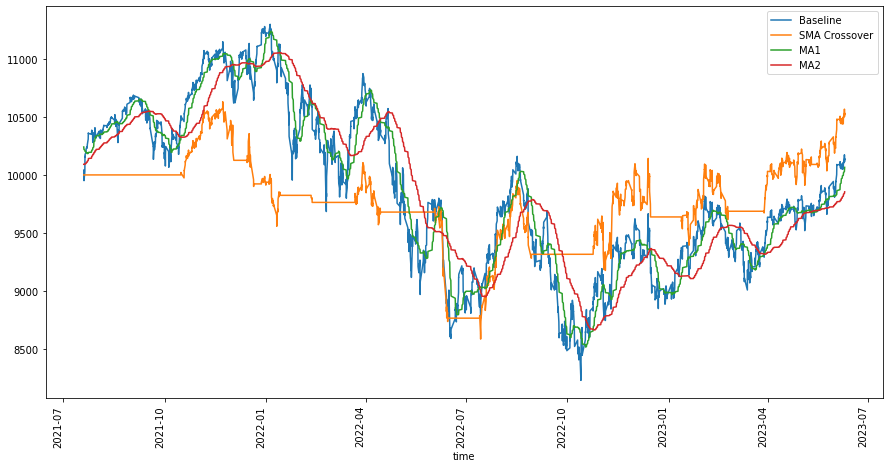

{'final_return_rate': 0.05252283053592777,
 'hit_rate': 1.0,
 'baseline_return_rate': 0.013276653070862343,
 'quarter_return_rates': [],
 'quarter_trades': [],
 'quarter_hit_rates': [],
 'baseline_return_rates': [],
 'balance_data':                           time      Baseline  SMA Crossover           MA1  \
 168  2021-07-19 09:30:00-04:00  10041.467611   10000.000000  10241.044522   
 169  2021-07-19 10:30:00-04:00   9989.280056   10000.000000  10238.141114   
 170  2021-07-19 11:30:00-04:00   9997.689054   10000.000000  10234.818964   
 171  2021-07-19 12:30:00-04:00   9976.910669   10000.000000  10230.911767   
 172  2021-07-19 13:30:00-04:00   9953.113817   10000.000000  10227.112559   
 ...                        ...           ...            ...           ...   
 3499 2023-06-09 11:30:00-04:00  10127.936121   10520.210804  10041.990462   
 3500 2023-06-09 12:30:00-04:00  10112.503687   10504.180642  10047.677006   
 3501 2023-06-09 13:30:00-04:00  10134.830132   10527.371834  1005

In [101]:
# Run the crossover backtester without shorting
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=False,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages = True,
            annual_taxes=True,
            tax_percentage=0.3,
            fee = 0
        )

backtest_results


/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


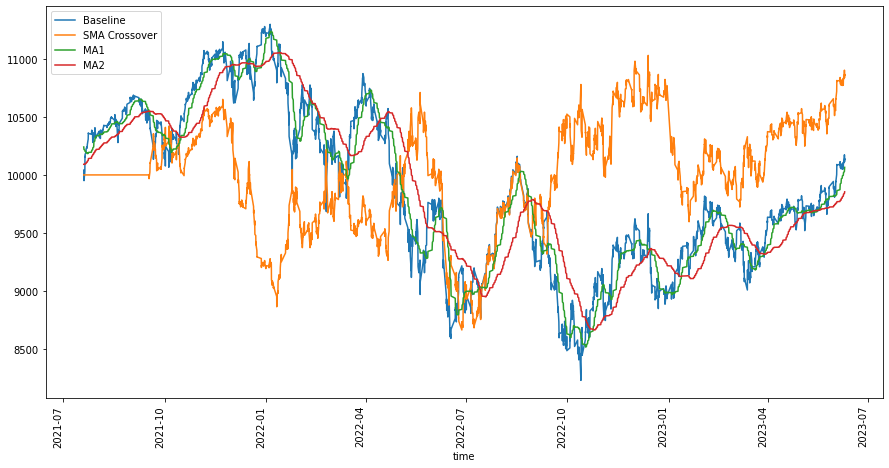

{'final_return_rate': 0.08600280388022252,
 'hit_rate': 0.0,
 'baseline_return_rate': 0.013276653070862343,
 'quarter_return_rates': [],
 'quarter_trades': [],
 'quarter_hit_rates': [],
 'baseline_return_rates': [],
 'balance_data':                           time      Baseline  SMA Crossover           MA1  \
 168  2021-07-19 09:30:00-04:00  10041.467611   10000.000000  10241.044522   
 169  2021-07-19 10:30:00-04:00   9989.280056   10000.000000  10238.141114   
 170  2021-07-19 11:30:00-04:00   9997.689054   10000.000000  10234.818964   
 171  2021-07-19 12:30:00-04:00   9976.910669   10000.000000  10230.911767   
 172  2021-07-19 13:30:00-04:00   9953.113817   10000.000000  10227.112559   
 ...                        ...           ...            ...           ...   
 3499 2023-06-09 11:30:00-04:00  10127.936121   10854.850935  10041.990462   
 3500 2023-06-09 12:30:00-04:00  10112.503687   10838.310865  10047.677006   
 3501 2023-06-09 13:30:00-04:00  10134.830132   10862.239752  1005

In [102]:
# Run the crossover backtester with shorting
backtest_results = sma_crossover_backtester(
            sampled_data = spy_data,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True,
            shorting_allowed=True,
            fixed_fee = True,
            record_balance = True,
            show_moving_averages=True,
            annual_taxes=True,
            tax_percentage=0.3, # taking 30% of gains as taxes
            fee = 0
        )

backtest_results


In [103]:
# Interpret backtest results
import statistics
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")

Hit Rate: 0.0
SMA Crossover Return Rate: 8.6 %
Buy & Hold Return Rate: 1.33 %


In [113]:
def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2



def run_multiple_backtests(shorting_allowed, num_runs):
    """
    shorting_allowed: bool
    num_runs: int
    """
    from tqdm import trange # for tracking progress

    # test lots of combinations
    ma_combinations = []
    median_return_rate_results = []
    stdev_return_rate_results = []
    profitable_quarters_results = [] 
    cumulative_return_results = []
    cumulative_baseline_return_results = []
    sharpe_ratios = []
    total_trades_results = []
    mean_trades_results = []

    # run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
    for x in trange(num_runs):
        ma1_length, ma2_length = random_ma_length_generator()
        ma_combinations.append((ma1_length, ma2_length))

        backtest_results = sma_crossover_backtester(
                sampled_data = spy_data,
                order_sizing = 1,
                ma1_length = ma1_length, 
                ma2_length = ma2_length, 
                starting_capital = 10000,
                shorting_allowed=shorting_allowed,
                fixed_fee=True,
                show_moving_averages=False,
                annual_taxes=True,
                tax_percentage=0.3,
                fee = 0,
                display_results=False,
                record_balance=False
            )
        
        #median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
        #stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
        profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
        cumulative_return = backtest_results['final_return_rate']
        cumulative_baseline_return = backtest_results["baseline_return_rate"]
        #sharpe_ratio = backtest_results["sharpe_ratio"]
        total_trades = sum([x for x in backtest_results['quarter_trades']])
        #mean_trades_per_quarter = total_trades/len(backtest_results['quarter_trades'])

        #median_return_rate_results.append(median_return_rate)
        #stdev_return_rate_results.append(stdev_return_rate)
        profitable_quarters_results.append(profitable_quarters)
        cumulative_return_results.append(cumulative_return)
        cumulative_baseline_return_results.append(cumulative_baseline_return)
        #sharpe_ratios.append(sharpe_ratio)
        total_trades_results.append(total_trades)
        #mean_trades_results.append(mean_trades_per_quarter)

    # compile results into a table for exploration
    optimization_results = pd.DataFrame()
    optimization_results["ma1_length"] = [x[0] for x in ma_combinations]
    optimization_results["ma2_length"] = [x[1] for x in ma_combinations]
    #optimization_results["median_return_rate"] = median_return_rate_results
    #optimization_results["stdev_return_rate"] = stdev_return_rate_results
    optimization_results["cumulative_return"] = cumulative_return_results
    optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
    optimization_results["profitable_quarters"] = profitable_quarters_results
    #optimization_results["sharpe_ratio"] = sharpe_ratios
    optimization_results["total_trades"] = total_trades_results
    #optimization_results["mean_trades_per_quarter"] = mean_trades_results

    #optimization_results.head()
    return optimization_results

# Generate Runs for Shorting/No-Shorting, Save to .csv

In [114]:
shorting_allowed_100_runs = run_multiple_backtests(shorting_allowed=True, num_runs = 100)
shorting_allowed_100_runs.to_csv("sma_crossover_shorting_allowed_100_runs.csv")
shorting_allowed_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1%|          | 1/100 [00:00<01:31,  1.08it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 2/100 [00:01<01:30,  1.08it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is try

,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades
0,557,614,0.162392,0.013277,0,0
1,257,524,-0.152108,0.013277,0,0
2,378,873,0.120927,0.013277,0,0
3,26,273,-0.116165,0.013277,0,0
4,115,463,-0.312616,0.013277,0,0
...,...,...,...,...,...,...
95,670,1074,0.128326,0.013277,0,0
96,676,796,0.043074,0.013277,0,0
97,341,1090,0.105338,0.013277,0,0
98,168,312,-0.385939,0.013277,0,0


In [120]:
# 60 of 100 runs were more profitable than buy and hold
len(shorting_allowed_100_runs[shorting_allowed_100_runs.cumulative_return > shorting_allowed_100_runs.cumulative_baseline_return])

60

In [117]:
no_shorting_100_runs = run_multiple_backtests(shorting_allowed=False, num_runs = 100)
no_shorting_100_runs.to_csv("sma_crossover_no_shorting_100_runs.csv")
no_shorting_100_runs

  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1%|          | 1/100 [00:00<01:15,  1.32it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 2/100 [00:01<01:19,  1.23it/s]/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is try

,ma1_length,ma2_length,cumulative_return,cumulative_baseline_return,profitable_quarters,total_trades
0,542,991,0.049297,0.013277,0,0
1,184,630,-0.084541,0.013277,0,0
2,279,498,-0.135259,0.013277,0,0
3,498,863,0.015723,0.013277,0,0
4,797,831,0.029655,0.013277,0,0
...,...,...,...,...,...,...
95,586,688,-1.000000,0.013277,0,0
96,804,1029,0.114862,0.013277,0,0
97,519,888,0.043644,0.013277,0,0
98,365,768,0.060523,0.013277,0,0


In [118]:
# 48 of 100 runs were more profitable than buy and hold
len(no_shorting_100_runs[no_shorting_100_runs.cumulative_return > no_shorting_100_runs.cumulative_baseline_return])

48